In [31]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, auc

data = pd.read_csv("/Users/matan/GitHub/Microbiome_Structure_Madagascar/data/data_processed/ML_module/ML_rattus_three_villages_rare.csv")
# Get only the important features that needed to be used in the Prediction model
features = ['season.x','sex.x','mass.x','age_repro.x','richness.x',
            'season.y','sex.y','mass.y','age_repro.y','richness.y',
           'distance','elevation','grid_attr','sm_community']

#identity = ['host_ID', 'asv_ID']
y_value = ['module']


def one_hot_encode_dataframe(df):
    # Get the list of categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Perform one-hot encoding for each categorical column
    one_hot_encoded_df = pd.get_dummies(df, columns=categorical_columns)
    
    return one_hot_encoded_df

def save_evaluation_metrics(y_true, y_pred_proba, output_file):
    """
    Save evaluation metrics (AUC, precision, recall, F1 score, confusion matrix) to a dictionary file.

    Parameters:
    y_true (array-like): True labels.
    y_pred_proba (array-like): Predicted probabilities of the positive class.
    output_file (str): File path to save the dictionary.
    """
    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)
    y_pred = (y_pred_proba > 0.5).astype(int)
    precision_val = precision_score(y_true, y_pred)
    recall_val = recall_score(y_true, y_pred)
    f1_val = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    # Save metrics to dictionary
    metrics_dict = {
        'AUC': auc_score,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1_val,
        'Confusion Matrix': cm
    }
    
    with open(output_file, 'wb') as file:
        pickle.dump(metrics_dict, file)

def plot_pr_roc_curves(y_true, y_pred_proba, output_prefix):
    """
    Plot Precision-Recall (PR) curve and Receiver Operating Characteristic (ROC) curve and save as PDF.

    Parameters:
    y_true (array-like): True labels.
    y_pred_proba (array-like): Predicted probabilities of the positive class.
    output_prefix (str): Prefix for the output PDF files.
    """
    # Plot PR curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.savefig(output_prefix + '_pr_curve.pdf')
    plt.close()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.savefig(output_prefix + '_roc_curve.pdf')
    plt.close()

def random_forest_hyperparameter_tuning(X, y, output_file_prefix, seed = 42):
    """
    Perform hyperparameter tuning for Random Forest classifier using 5-fold cross-validation.
    Evaluate the tuned model's performance on a separate test set and calculate AUC score.

    Parameters:
    X (array-like): Feature matrix.
    y (array-like): Target label.
    output_file_prefix (str): Prefix for the output files.

    Returns:
    best_params (dict): Best hyperparameters found during tuning.
    """
    # Split dataset into training and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Define Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=seed)
    
    # Define hyperparameters grid for tuning
    param_grid = {
        'n_estimators': [10, 30, 80],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    param_grid = {
        'n_estimators': [80],
        'max_depth': [10],
        'min_samples_split': [5],
        'min_samples_leaf': [1]
    }
    
    # Perform GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                               cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get best hyperparameters
    best_params = grid_search.best_params_
    
    # Evaluate tuned model on test set
    best_rf_model = grid_search.best_estimator_
    y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Save evaluation metrics
    save_evaluation_metrics(y_test, y_pred_proba, output_file_prefix + '_metrics.pkl')
    
    # Plot PR and ROC curves
    plot_pr_roc_curves(y_test, y_pred_proba, output_file_prefix)
    
    return best_params, grid_search, X_test, y_test, y_pred_proba

# Example usage:
# Assuming 'X' is your feature matrix and 'y' is your target label
# best_params = random_forest_hyperparameter_tuning(X, y, 'output')
# print("Best hyperparameters:", best_params)


In [32]:
X = one_hot_encode_dataframe(data[features])
y = data['module']


In [33]:
# for i in range(10):
i=10

best_params, grid_search, X_test, y_test, y_pred_proba = random_forest_hyperparameter_tuning(X, y, 'out_{}'.format(i), seed = i)
print("Best hyperparameters:", best_params)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 80}


<Axes: >

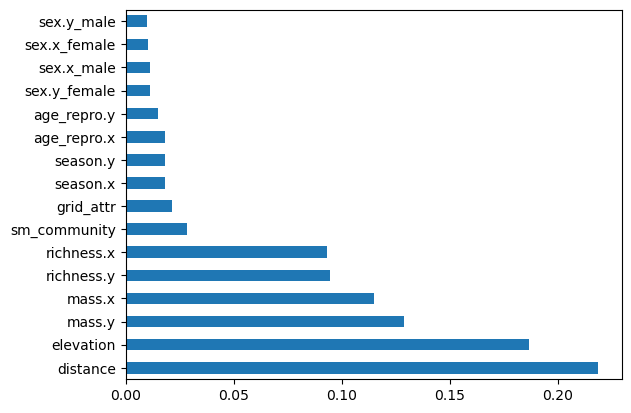

In [34]:
best_model = grid_search.best_estimator_#._final_estimator
feature_names = best_model.feature_names_in_
importance  = best_model.feature_importances_
feature_importance = pd.Series(importance, index=feature_names).nlargest(20)
feature_importance.plot(kind='barh')

In [35]:
feature_importance.rename_axis('feature').rename('value').to_csv('feature_importance_rare.csv')

In [36]:
test_set = pd.concat([X_test.reset_index(drop=False), 
                      pd.DataFrame(y_test).reset_index(drop=True).rename(columns={'Link':'y_true'}), 
                      pd.DataFrame(y_pred_proba).rename(columns={0:'y_proba'})], axis=1)
test_set.to_csv('test_set_rare.csv')